In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import sys
import os
import torch
import numpy as np
import scipy

In [7]:
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "../../.."))

PRINT_EVERY = 1000

## Start: Importing local packages. As I don't know how to run it as module
## with torchrun  (e.g., python -m trainer.Coronary_ddp_trainer)

if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.data.IBM_data_loader import generate_fluid_testing_dataset
from src.utils.utils import lp_error
from src.utils.logger import Logging
from src.utils.color import model_color
from src.utils.plot_loss import plot_loss_history
from src.utils.plotting_regular_2D import plot_time_profile_regular_data_IBM
from src.utils.plotting_regular_2D import draw_contourf_regular_2D
from src.utils.plotting_irregular_2D_interface import draw_contourf_irregular_2D

DEVICE = "cpu"  # torch.device("cuda" if torch.cuda.is_available() else "cpu")

# file_path = "/home/vlq26735/saiful/afrah/datasets/IBM/IB_PINN3.mat"

# h=  0.498715
# k=  0.6851750000000001
# rx=  0.209685
# ry=  0.21008499999999997

In [8]:
TEST_CHECKPOINT_PATH = os.path.join(PROJECT_ROOT, "testing_checkpoints/fsi")
logger = Logging(TEST_CHECKPOINT_PATH)
model_dirname = logger.get_output_dir()

logger.print(f"Device used {DEVICE}")

INFO:src.utils.logger:Device used cpu


### Load  and reshape the Testing Dataset if required

In [9]:
def load_data(Fluid_data, key):
    return Fluid_data[key]


DATA_FILE = "../../../data/Fluid_trainingData.mat"

TEST_DATA_PATH = "../../../data/IB_PINN3.mat"


[time_fluid, x_fluid, y_fluid, u_fluid, v_fluid, p_fluid, fx_fluid, fy_fluid] = (
    generate_fluid_testing_dataset(TEST_DATA_PATH)
)

test_torch_data = torch.tensor(
    np.concatenate([time_fluid, x_fluid, y_fluid, u_fluid, v_fluid, p_fluid], axis=1),
    dtype=torch.float32,
).to(DEVICE)


Fluid_data = scipy.io.loadmat(DATA_FILE)

interface_np = load_data(Fluid_data, "Solid_interface")

# Calculate mean and std for all columns in interface
mean_interface = interface_np.mean(axis=0, keepdims=True)[0]
std_interface = interface_np.std(axis=0, keepdims=True)[0]
mean_interface = torch.tensor(mean_interface, dtype=torch.float32).to(DEVICE)
std_interface = torch.tensor(std_interface, dtype=torch.float32).to(DEVICE)


time_interface = interface_np[:, 0].flatten()[:, None]  # test_data[0]
x_interface = interface_np[:, 1].flatten()[:, None]  # test_data[1]
y_interface = interface_np[:, 2].flatten()[:, None]  # test_data[2]
u_interface = interface_np[:, 3].flatten()[:, None]  # test_data[2]
v_interface = interface_np[:, 4].flatten()[:, None]  # test_data[2]
p_interface = interface_np[:, 5].flatten()[:, None]  # test_data[2]
fx_interface = interface_np[:, 6].flatten()[:, None]  # test_data[3]
fy_interface = interface_np[:, 7].flatten()[:, None]  # test_data[4]


time_interface_tensor = torch.tensor(time_interface, dtype=torch.float32).to(DEVICE)
x_interface_tensor = torch.tensor(x_interface, dtype=torch.float32).to(DEVICE)
y_interface_tensor = torch.tensor(y_interface, dtype=torch.float32).to(DEVICE)

# Ensure input is on the same device (GPU)
input_interface = torch.cat(
    [time_interface_tensor, x_interface_tensor, y_interface_tensor], axis=1
)

In [10]:
Bspline_MODEL_PATH = os.path.join(
    PROJECT_ROOT, "checkpoints/fsi/2024-10-25_20-41-08-372085/model.pth"
)

### Load B-spline Model

In [11]:
# Initialize models to None


fluid_model = None

# Load the state from the saved model
state = torch.load(Bspline_MODEL_PATH)
config = state.get("config", {})
loss_history = state.get("loss_history", [])
solver = config.get("solver")


# Log model summary and configuration
logger.print("_summary of the model _")
logger.print("model path:", Bspline_MODEL_PATH)
logger.print("model configuration:")
for key, value in config.items():
    logger.print(f"{key} : {value}")

# Extract model configuration from state
model_activation_name = config.get("activation", "Tanh")
network_fluid = config.get("network_fluid")
network_force = config.get("network_force")
loss_history = state.get("loss_history")

fluid_data_mean = state.get("fluid_data_mean").to(DEVICE)
fluid_data_std = state.get("fluid_data_std").to(DEVICE)
solid_data_mean = state.get("solid_data_mean").to(DEVICE)
solid_data_std = state.get("solid_data_std").to(DEVICE)


SOLVER_TO_MODULE = {
    "tanh": "src.nn.tanh",
    "xsig": "src.nn.xsigmoid",
    "bspline": "src.nn.bspline",
}

# Dynamically import the correct module and class
if solver in SOLVER_TO_MODULE:
    module = __import__(SOLVER_TO_MODULE[solver], fromlist=["PINNKAN"])
    PINNKAN = getattr(module, "PINNKAN")

    # Initialize fluid and solid models
    bspline_model_fluid = PINNKAN(network_fluid, model_activation_name).to(DEVICE)
    bspline_model_force = PINNKAN(network_force, model_activation_name).to(DEVICE)

# Plot the loss history if available

# Load the saved state dictionaries into the models
bspline_model_fluid.load_state_dict(state["model_fluid_state_dict"])
bspline_model_force.load_state_dict(state["model_force_state_dict"])

/tmp/ipykernel_1690609/175430852.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(Bspline_MODEL_PATH)
INFO:src.utils.logger:_summary of the model _
INF

<All keys matched successfully>

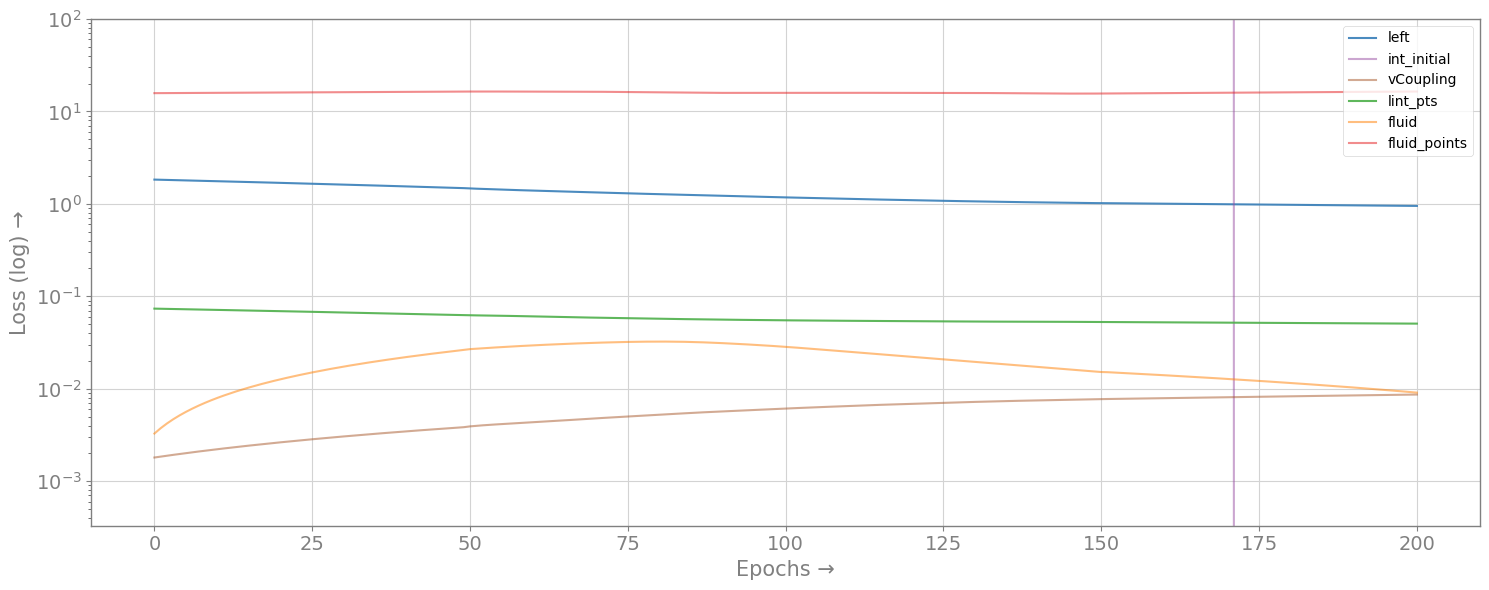

In [12]:
trim_len = 0
bc_loss = (
    np.array(loss_history["left"][trim_len:])
    + np.array(loss_history["right"][trim_len:])
    + np.array(loss_history["bottom"][trim_len:])
    + np.array(loss_history["up"][trim_len:])
    + np.array(loss_history["initial"][trim_len:])
)

data_list = [
    {
        "data": bc_loss,
        "color": model_color["bspline"],
        "name": "left",
        "alpha": 0.9,
        "window": 100,
        "show_avg": False,
        "show_lower": False,
    },
    {
        "data": loss_history["int_initial"][trim_len:],
        "color": model_color["tanh"],
        "name": "int_initial",
        "alpha": 0.5,
        "window": 100,
        "show_avg": False,
        "show_lower": False,
    },
    {
        "data": loss_history["vCoupling"][trim_len:],
        "color": model_color["grbf"],
        "name": "vCoupling",
        "alpha": 0.5,
        "window": 100,
        "show_avg": False,
        "show_lower": False,
    },
    {
        "data": loss_history["lint_pts"][trim_len:],
        "color": model_color["fourier"],
        "name": "lint_pts",
        "alpha": 0.9,
        "window": 100,
        "show_avg": False,
        "show_lower": False,
    },
    {
        "data": loss_history["fluid"][trim_len:],
        "color": model_color["param_tanh"],
        "name": "fluid",
        "alpha": 0.5,
        "window": 100,
        "show_avg": False,
        "show_lower": False,
    },
    {
        "data": loss_history["fluid_points"][trim_len:],
        "color": model_color["chebyshev"],
        "name": "fluid_points",
        "alpha": 0.5,
        "window": 100,
        "show_avg": False,
        "show_lower": False,
    },
]


plot_loss_history(
    data_list,
    os.path.join(logger.get_output_dir(), "loss_history_fsi.png"),
    y_max=100,
)

## Precition on the Fluid and the Solid using BSpline Model

In [13]:
with torch.no_grad():
    bspline_fluid_predictions1 = bspline_model_fluid.forward(
        test_torch_data[:, :3], fluid_data_mean[:3], fluid_data_std[:3]
    )
    bspline_fluid_predictions2 = bspline_model_force.forward(
        test_torch_data[:, :3], fluid_data_mean[:3], fluid_data_std[:3]
    )
if bspline_fluid_predictions1.is_cuda:
    bspline_fluid_predictions1 = bspline_fluid_predictions1.cpu()
    bspline_fluid_predictions2 = bspline_fluid_predictions2.cpu()

In [14]:
u_pred_fluid = bspline_fluid_predictions1[:, 0:1].numpy()
v_pred_fluid = bspline_fluid_predictions1[:, 1:2].numpy()
p_pred_fluid = bspline_fluid_predictions1[:, 2:3].numpy()
fx_pred_fluid = bspline_fluid_predictions2[:, 0:1].numpy()
fy_pred_fluid = bspline_fluid_predictions2[:, 1:2].numpy()

#

text = "RelL2_"
# logger.print("\n Relative L2 ERROR:")
u_error2 = lp_error(u_pred_fluid, u_fluid, (text + "U%"), logger, 2)
v_error2 = lp_error(v_pred_fluid, v_fluid, (text + "V%"), logger, 2)
p_error2 = lp_error(p_pred_fluid, p_fluid, (text + "P%"), logger, 2)
fx_error2 = lp_error(fx_pred_fluid, fx_fluid, (text + "Fx%"), logger, 2)
fy_error2 = lp_error(fy_pred_fluid, fy_fluid, (text + "Fy%"), logger, 2)

mean_velocity = (u_error2 + v_error2) / 2
print(f"mean velocity: {mean_velocity:0.3e}")

mean_force = (fx_error2 + fy_error2) / 2
print(f"mean_force: {mean_force:0.3e}")

print(f"p_error2: {p_error2:0.3e}")

INFO:src.utils.logger:RelL2_U%  : 98.38 
INFO:src.utils.logger:RelL2_V%  : 86.29 
INFO:src.utils.logger:RelL2_P%  : 95.35 
INFO:src.utils.logger:RelL2_Fx%  : 101.28 
INFO:src.utils.logger:RelL2_Fy%  : 100.24 


mean velocity: 9.234e+01
mean_force: 1.008e+02
p_error2: 9.535e+01


### Prediction on the Interface using BSpline Model

In [15]:
# Forward pass through the fluid model (assuming it's already on the GPU)
with torch.no_grad():
    bspline_prediction_interface1 = bspline_model_fluid.forward(
        input_interface, mean_interface[:3], std_interface[:3]
    )
    bspline_prediction_interface2 = bspline_model_force.forward(
        input_interface, mean_interface[:3], std_interface[:3]
    )
if bspline_prediction_interface1.is_cuda:
    bspline_prediction_interface1 = bspline_prediction_interface1.cpu()
    bspline_prediction_interface2 = bspline_prediction_interface2.cpu()

In [16]:
u_pred_interface = bspline_prediction_interface1[:, 0:1].numpy()
v_pred_interface = bspline_prediction_interface1[:, 1:2].numpy()
p_pred_interface = bspline_prediction_interface1[:, 2:3].numpy()
fx_pred_interface = bspline_prediction_interface2[:, 0:1].numpy()
fy_pred_interface = bspline_prediction_interface2[:, 1:2].numpy()


text = "on the interface : RelL2_"
print("on the interface")

# Calculate relative L2 errors

bspline_u_error_interface = lp_error(
    u_pred_interface, u_interface, (text + "U%"), logger, 2
)
bspline_v_error_interface = lp_error(
    v_pred_interface, v_interface, (text + "V%"), logger, 2
)
bspline_p_pred_error_interface = lp_error(
    p_pred_interface, p_interface, (text + "P%"), logger, 2
)
bspline_fx_error_interface = lp_error(
    fx_pred_interface, fx_interface, (text + "Fx%"), logger, 2
)
bspline_fy_error_interface = lp_error(
    fy_pred_interface, fy_interface, (text + "Fy%"), logger, 2
)

INFO:src.utils.logger:on the interface : RelL2_U%  : 126.54 
INFO:src.utils.logger:on the interface : RelL2_V%  : 88.83 
INFO:src.utils.logger:on the interface : RelL2_P%  : 100.32 
INFO:src.utils.logger:on the interface : RelL2_Fx%  : 100.00 
INFO:src.utils.logger:on the interface : RelL2_Fy%  : 100.00 


on the interface


### Load MLP model

In [13]:
MLP_MODEL_PATH = os.path.join(
    PROJECT_ROOT, "checkpoints/fsi/2024-10-25_21-01-16-546693/model.pth"
)

In [14]:
# Initialize models to None


# Load the state from the saved model
state = torch.load(MLP_MODEL_PATH)
config = state.get("config", {})
loss_history = state.get("loss_history", [])
solver = config.get("solver")

# Log model summary and configuration
logger.print("_summary of the model _")
logger.print("model path:", MLP_MODEL_PATH)
logger.print("model configuration:")
for key, value in config.items():
    logger.print(f"{key} : {value}")

# Extract model configuration from state
model_activation_name = config.get("activation", "Tanh")
network_fluid = config.get("network_fluid")
network_force = config.get("network_force")
loss_history = state.get("loss_history")

fluid_data_mean = state.get("fluid_data_mean").to(DEVICE)
fluid_data_std = state.get("fluid_data_std").to(DEVICE)
solid_data_mean = state.get("solid_data_mean").to(DEVICE)
solid_data_std = state.get("solid_data_std").to(DEVICE)


SOLVER_TO_MODULE = {
    "tanh": "src.nn.tanh",
    "xsig": "src.nn.xsigmoid",
    "bspline": "src.nn.bspline",
}

# Dynamically import the correct module and class
if solver in SOLVER_TO_MODULE:
    module = __import__(SOLVER_TO_MODULE[solver], fromlist=["PINNKAN"])
    PINNKAN = getattr(module, "PINNKAN")

    # Initialize fluid and solid models
    mlp_model_fluid = PINNKAN(network_fluid, model_activation_name).to(DEVICE)
    mlp_model_force = PINNKAN(network_force, model_activation_name).to(DEVICE)

# Plot the loss history if available

# Load the saved state dictionaries into the models
mlp_model_fluid.load_state_dict(state["model_fluid_state_dict"])
mlp_model_force.load_state_dict(state["model_force_state_dict"])

/tmp/ipykernel_1510428/1868564886.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(MLP_MODEL_PATH)
INFO:src.utils.logger:_summary of the model _
INFO:s

<All keys matched successfully>

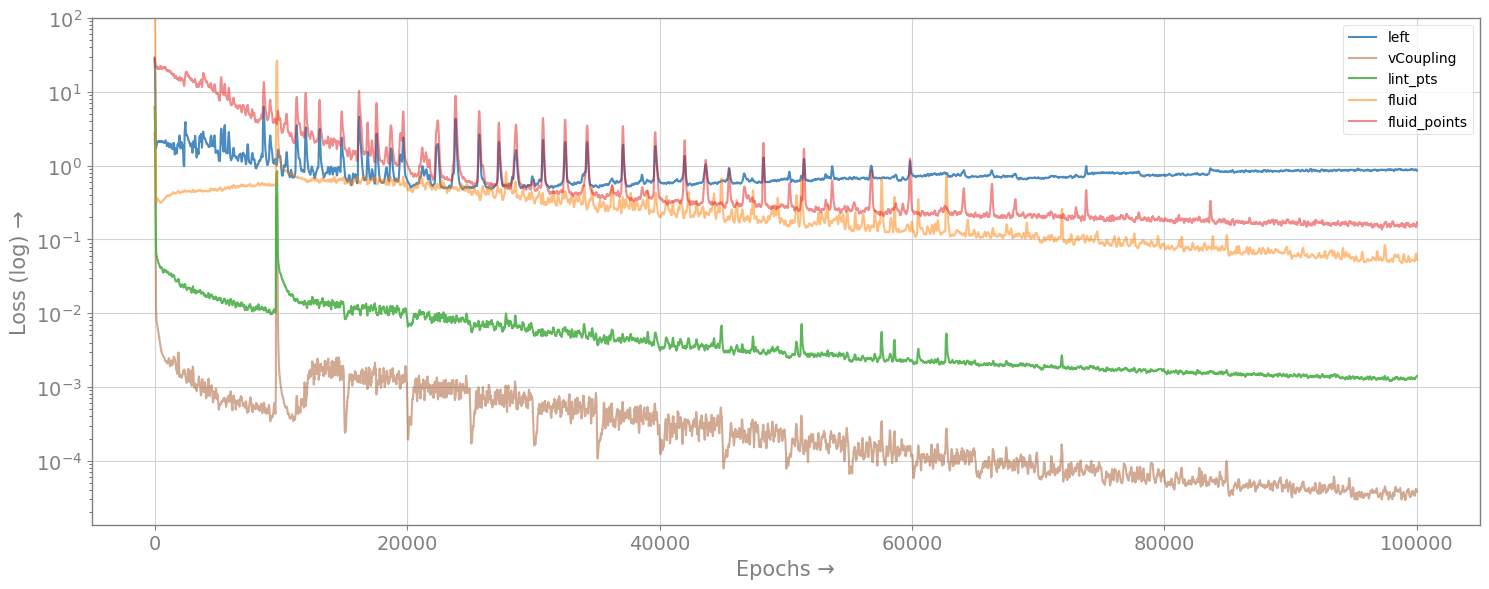

In [15]:
trim_len = 0
bc_loss = (
    np.array(loss_history["left"][trim_len:])
    + np.array(loss_history["right"][trim_len:])
    + np.array(loss_history["bottom"][trim_len:])
    + np.array(loss_history["up"][trim_len:])
    + np.array(loss_history["initial"][trim_len:])
)

data_list = [
    {
        "data": bc_loss,
        "color": model_color["bspline"],
        "name": "left",
        "alpha": 0.9,
        "window": 100,
        "show_avg": False,
        "show_lower": False,
    },
    # {
    #     "data": loss_history["int_initial"][trim_len:],
    #     "color": model_color["tanh"],
    #     "name": "int_initial",
    #     "alpha": 0.5,
    #     "window": 100,
    #     "show_avg": False,
    #     "show_lower": False,
    # },
    {
        "data": loss_history["vCoupling"][trim_len:],
        "color": model_color["grbf"],
        "name": "vCoupling",
        "alpha": 0.5,
        "window": 100,
        "show_avg": False,
        "show_lower": False,
    },
    {
        "data": loss_history["lint_pts"][trim_len:],
        "color": model_color["fourier"],
        "name": "lint_pts",
        "alpha": 0.9,
        "window": 100,
        "show_avg": False,
        "show_lower": False,
    },
    {
        "data": loss_history["fluid"][trim_len:],
        "color": model_color["param_tanh"],
        "name": "fluid",
        "alpha": 0.5,
        "window": 100,
        "show_avg": False,
        "show_lower": False,
    },
    {
        "data": loss_history["fluid_points"][trim_len:],
        "color": model_color["chebyshev"],
        "name": "fluid_points",
        "alpha": 0.5,
        "window": 100,
        "show_avg": False,
        "show_lower": False,
    },
]


plot_loss_history(
    data_list,
    os.path.join(logger.get_output_dir(), "loss_history_fsi.png"),
    y_max=100,
)

## Model predictions on the test data

In [16]:
with torch.no_grad():
    mlp_fluid_velocity_predictions1 = mlp_model_fluid.forward(
        test_torch_data[:, :3], fluid_data_mean[:3], fluid_data_std[:3]
    )
    mlp_fluid_velocity_predictions2 = mlp_model_force.forward(
        test_torch_data[:, :3], fluid_data_mean[:3], fluid_data_std[:3]
    )
if mlp_fluid_velocity_predictions1.is_cuda:
    mlp_fluid_velocity_predictions1 = mlp_fluid_velocity_predictions1.cpu()
    mlp_fluid_velocity_predictions2 = mlp_fluid_velocity_predictions2.cpu()

u_pred_fluid = mlp_fluid_velocity_predictions1[:, 0:1].numpy()
v_pred_fluid = mlp_fluid_velocity_predictions1[:, 1:2].numpy()
p_pred_fluid = mlp_fluid_velocity_predictions1[:, 2:3].numpy()
fx_pred_fluid = mlp_fluid_velocity_predictions2[:, 0:1].numpy()
fy_pred_fluid = mlp_fluid_velocity_predictions2[:, 1:2].numpy()

### Calculate relative L2 errors percetages

In [17]:
text = "RelL2_"
# logger.print("\n Relative L2 ERROR:")
u_error2 = lp_error(u_pred_fluid, u_fluid, (text + "U%"), logger, 2)
v_error2 = lp_error(v_pred_fluid, v_fluid, (text + "V%"), logger, 2)
p_error2 = lp_error(p_pred_fluid, p_fluid, (text + "P%"), logger, 2)
fx_error2 = lp_error(fx_pred_fluid, fx_fluid, (text + "Fx%"), logger, 2)
fy_error2 = lp_error(fy_pred_fluid, fy_fluid, (text + "Fy%"), logger, 2)

mean_velocity = (u_error2 + v_error2) / 2
print(f"mean velocity: {mean_velocity:0.3e}")

mean_force = (fx_error2 + fy_error2) / 2
print(f"mean_force: {mean_force:0.3e}")

print(f"p_error2: {p_error2:0.3e}")

INFO:src.utils.logger:RelL2_U%  : 20.16 
INFO:src.utils.logger:RelL2_V%  : 15.15 
INFO:src.utils.logger:RelL2_P%  : 37.03 
INFO:src.utils.logger:RelL2_Fx%  : 89.15 
INFO:src.utils.logger:RelL2_Fy%  : 86.53 


mean velocity: 1.765e+01
mean_force: 8.784e+01
p_error2: 3.703e+01


### Prediction on the Interface using MLP model

In [18]:
# Forward pass through the fluid model (assuming it's already on the GPU)
with torch.no_grad():
    mlp_prediction_interface1 = mlp_model_fluid.forward(
        input_interface, mean_interface[:3], std_interface[:3]
    )
    mlp_prediction_interface2 = mlp_model_force.forward(
        input_interface, mean_interface[:3], std_interface[:3]
    )
if mlp_prediction_interface1.is_cuda:
    mlp_prediction_interface1 = mlp_prediction_interface1.cpu()
u_pred_interface = mlp_prediction_interface1[:, 0:1].numpy()
v_pred_interface = mlp_prediction_interface1[:, 1:2].numpy()
p_pred_interface = mlp_prediction_interface1[:, 2:3].numpy()
fx_pred_interface = mlp_prediction_interface2[:, 0:1].numpy()
fy_pred_interface = mlp_prediction_interface2[:, 1:2].numpy()

### Calculate relative L2 errors on the interface

In [19]:
text = "on the interface : RelL2_"
print("on the interface")

# Calculate relative L2 errors

u_error_interface = lp_error(u_pred_interface, u_interface, (text + "U%"), logger, 2)
v_error_interface = lp_error(v_pred_interface, v_interface, (text + "V%"), logger, 2)
p_pred_error_interface = lp_error(
    p_pred_interface, p_interface, (text + "P%"), logger, 2
)
fx_error_interface = lp_error(
    fx_pred_interface, fx_interface, (text + "Fx%"), logger, 2
)
fy_error_interface = lp_error(
    fy_pred_interface, fy_interface, (text + "Fy%"), logger, 2
)

INFO:src.utils.logger:on the interface : RelL2_U%  :  5.16 
INFO:src.utils.logger:on the interface : RelL2_V%  :  2.92 
INFO:src.utils.logger:on the interface : RelL2_P%  : 98.72 
INFO:src.utils.logger:on the interface : RelL2_Fx%  : 100.00 
INFO:src.utils.logger:on the interface : RelL2_Fy%  : 99.99 


on the interface


### Combine the precitions of MLP and BSpline if required

In [20]:
combine_fluid = True
if combine_fluid:
    fluid_predictions_velocity = (
        bspline_fluid_predictions1 + mlp_fluid_velocity_predictions1
    ) / 2
    fluid_predictions_force = (
        bspline_fluid_predictions2 + mlp_fluid_velocity_predictions2
    ) / 2

    u_pred_fluid = fluid_predictions_velocity[:, 0:1].numpy()
    v_pred_fluid = fluid_predictions_velocity[:, 1:2].numpy()
    p_pred_fluid = fluid_predictions_velocity[:, 2:3].numpy()
    fx_pred_fluid = fluid_predictions_force[:, 0:1].numpy()
    fy_pred_fluid = fluid_predictions_force[:, 1:2].numpy()

    text = "Fluid RelL2_"
    # logger.print("\n Relative L2 ERROR:")
    u_error2 = lp_error(u_pred_fluid, u_fluid, (text + "U%"), logger, 2)
    v_error2 = lp_error(v_pred_fluid, v_fluid, (text + "V%"), logger, 2)
    p_error2 = lp_error(p_pred_fluid, p_fluid, (text + "P%"), logger, 2)
    fx_error2 = lp_error(fx_pred_fluid, fx_fluid, (text + "Fx%"), logger, 2)
    fy_error2 = lp_error(fy_pred_fluid, fy_fluid, (text + "Fy%"), logger, 2)

    mean_velocity = (u_error2 + v_error2) / 2
    print(f"mean velocity: {mean_velocity:0.3e}")

    mean_force = (fx_error2 + fy_error2) / 2
    print(f"mean_force: {mean_force:0.3e}")

    print(f"p_error2: {p_error2:0.3e}")


combine_interface = True
if combine_fluid:
    interface_predictions = (
        mlp_prediction_interface1 + bspline_prediction_interface1
    ) / 2
    interface_predictions = (
        mlp_prediction_interface1 + bspline_prediction_interface1
    ) / 2
    u_pred_interface = interface_predictions[:, 0:1].numpy()
    v_pred_interface = interface_predictions[:, 1:2].numpy()
    p_pred_interface = interface_predictions[:, 2:3].numpy()
    fx_pred_interface = interface_predictions[:, 0:1].numpy()
    fy_pred_interface = interface_predictions[:, 1:2].numpy()
    text = "Interface : RelL2_"

    # Calculate relative L2 errors

    u_error_interface = lp_error(
        u_pred_interface, u_interface, (text + "U%"), logger, 2
    )
    v_error_interface = lp_error(
        v_pred_interface, v_interface, (text + "V%"), logger, 2
    )
    p_pred_error_interface = lp_error(
        p_pred_interface, p_interface, (text + "P%"), logger, 2
    )
    fx_error_interface = lp_error(
        fx_pred_interface, fx_interface, (text + "Fx%"), logger, 2
    )
    fy_error_interface = lp_error(
        fy_pred_interface, fy_interface, (text + "Fy%"), logger, 2
    )

INFO:src.utils.logger:Fluid RelL2_U%  : 14.40 
INFO:src.utils.logger:Fluid RelL2_V%  : 10.48 
INFO:src.utils.logger:Fluid RelL2_P%  : 34.37 
INFO:src.utils.logger:Fluid RelL2_Fx%  : 68.26 
INFO:src.utils.logger:Fluid RelL2_Fy%  : 67.53 
INFO:src.utils.logger:Interface : RelL2_U%  :  2.62 
INFO:src.utils.logger:Interface : RelL2_V%  :  1.69 
INFO:src.utils.logger:Interface : RelL2_P%  : 74.61 
INFO:src.utils.logger:Interface : RelL2_Fx%  : 100.00 
INFO:src.utils.logger:Interface : RelL2_Fy%  : 100.00 


mean velocity: 1.244e+01
mean_force: 6.790e+01
p_error2: 3.437e+01


### Draw the solid and the fluid prediction

In [14]:
tstep = 101
xstep = 102
ystep = 102
part = "Fluid"
N_data = xstep * ystep

steps = [tstep, xstep, ystep]
txy = [x_fluid, y_fluid, time_fluid]

plot_time_profile_regular_data_IBM(
    logger.get_output_dir(), steps, txy, u_fluid, u_pred_fluid, "$u$"
)
plot_time_profile_regular_data_IBM(
    logger.get_output_dir(), steps, txy, v_fluid, v_pred_fluid, "$v$"
)
plot_time_profile_regular_data_IBM(
    logger.get_output_dir(), steps, txy, p_fluid, p_pred_fluid, "$p$"
)
plot_time_profile_regular_data_IBM(
    logger.get_output_dir(), steps, txy, fx_fluid, fx_pred_fluid, "_$Fx$_"
)
plot_time_profile_regular_data_IBM(
    logger.get_output_dir(), steps, txy, fy_fluid, fy_pred_fluid, "_$Fy$_"
)


tstep = 101
xstep = 102
ystep = 102

#  t = tf.reshape(tstep,N_data)[:,0].T
tf100 = time_fluid.reshape(tstep, xstep, ystep)[:, 0, 0]
fluid_x = x_fluid.reshape(tstep, xstep, ystep)[0, :, 0]  # .reshape(100,100)[0,:]
fluid_y = y_fluid.reshape(tstep, xstep, ystep)[0, 0, :]  # .reshape(100,100)[:,0]

u_fluid_cfd_reshape = u_fluid.reshape(tstep, xstep, ystep).transpose((0, 2, 1))
v_fluid_cfd_reshape = v_fluid.reshape(tstep, xstep, ystep).transpose((0, 2, 1))
p_fluid_cfd_reshape = p_fluid.reshape(tstep, xstep, ystep).transpose((0, 2, 1))
fx_fluid_cfd_reshape = fx_fluid.reshape(tstep, xstep, ystep).transpose((0, 2, 1))
fy_fluid_cfd_reshape = fy_fluid.reshape(tstep, xstep, ystep).transpose((0, 2, 1))

u_fluid_pred_reshape = u_pred_fluid.reshape(tstep, xstep, ystep).transpose((0, 2, 1))
v_fluid_pred_reshape = v_pred_fluid.reshape(tstep, xstep, ystep).transpose((0, 2, 1))
p_fluid_pred_reshape = p_pred_fluid.reshape(tstep, xstep, ystep).transpose((0, 2, 1))
fx_fluid_pred_reshape = fx_pred_fluid.reshape(tstep, xstep, ystep).transpose((0, 2, 1))
fy_fluid_pred_reshape = fy_pred_fluid.reshape(tstep, xstep, ystep).transpose((0, 2, 1))

u_error_fluid = np.abs(u_fluid_cfd_reshape - u_fluid_pred_reshape)
v_error_fluid = np.abs(v_fluid_cfd_reshape - v_fluid_pred_reshape)
p_error_fluid = np.abs(p_fluid_cfd_reshape - p_fluid_pred_reshape)
fx_error_fluid = np.abs(fx_fluid_cfd_reshape - fx_fluid_pred_reshape)
fy_error_fluid = np.abs(fy_fluid_cfd_reshape - fy_fluid_pred_reshape)

fluid_data = [
    u_fluid_pred_reshape,
    v_fluid_pred_reshape,
    p_fluid_pred_reshape,
    fx_fluid_pred_reshape,
    fy_fluid_pred_reshape,
    u_fluid_cfd_reshape,
    v_fluid_cfd_reshape,
    p_fluid_cfd_reshape,
    fx_fluid_cfd_reshape,
    fy_fluid_cfd_reshape,
    u_error_fluid,
    v_error_fluid,
    p_error_fluid,
    fx_error_fluid,
    fy_error_fluid,
]

nrows_ncols = (3, 5)
time_values = [99, 90, 70, 50, 20, 0]
titles = [
    "u_pinn",
    "v_pinn",
    "p_pinn",
    "fx_pinn",
    "fy_pinn",
    "u_cfd",
    "v_cfd",
    "p_cfd",
    "fx_cfd",
    "fy_cfd",
    "error_u",
    "error_v",
    "error_p",
    "error_fx",
    "error_fy",
]

draw_contourf_regular_2D(
    tf100,
    fluid_x,
    fluid_y,
    fluid_data,
    titles,
    nrows_ncols,
    time_values,
    1.0,
    1.0,
    model_dirname,
    15,
    12,
    5,
    fontsize=9.5,
    labelsize=9.5,
    axes_pad=1.0,
)

### Draw Interface Data

In [15]:
tstep = 101
N_data = int(time_interface.shape[0] / tstep)

#  t = tf.reshape(tstep,N_data)[:,0].T
tf100 = time_interface.reshape(tstep, N_data)[:, 0].T
interface_x = x_interface.reshape(tstep, N_data)[0, :]
interface_y = y_interface.reshape(tstep, N_data)[0, :]

u_interface_reshape = u_interface.reshape(tstep, N_data)
v_interface_reshape = v_interface.reshape(tstep, N_data)
p_interface_reshape = p_interface.reshape(tstep, N_data)
fx_interface_reshape = fx_interface.reshape(tstep, N_data)
fy_interface_reshape = fy_interface.reshape(tstep, N_data)


u_pred_interface_reshape = u_pred_interface.reshape(tstep, N_data)
v_pred_interface_reshape = v_pred_interface.reshape(tstep, N_data)
p_pred_interface_reshape = p_pred_interface.reshape(tstep, N_data)
fx_pred_interface_reshape = fx_pred_interface.reshape(tstep, N_data)
fy_pred_interface_reshape = fy_pred_interface.reshape(tstep, N_data)

u_error_interface = np.abs(u_interface_reshape - u_pred_interface_reshape)
v_error_interface = np.abs(v_interface_reshape - v_pred_interface_reshape)
p_error_interface = np.abs(p_interface_reshape - p_pred_interface_reshape)
fx_error_interface = np.abs(fx_interface_reshape - fx_pred_interface_reshape)
fy_error_interface = np.abs(fy_interface_reshape - fy_pred_interface_reshape)

nrows_ncols = (3, 5)
time_values = [0, 50, 99]
interface_data = [
    u_pred_interface_reshape,
    v_pred_interface_reshape,
    p_pred_interface_reshape,
    fx_pred_interface_reshape,
    fy_pred_interface_reshape,
    u_interface_reshape,
    v_interface_reshape,
    p_interface_reshape,
    fx_interface_reshape,
    fy_interface_reshape,
    u_error_interface,
    v_error_interface,
    p_error_interface,
    fx_error_interface,
    fy_error_interface,
]

titles = [
    "u_pinn",
    "v_pinn",
    "p_pinn",
    "fx_pinn",
    "fy_pinn",
    "u_cfd",
    "v_cfd",
    "p_cfd",
    "fx_cfd",
    "fy_cfd",
    "u_error",
    "v_error",
    "p_error",
    "fx_error",
    "fy_error",
]

fig_size = (25, 25)
draw_contourf_irregular_2D(
    tf100,
    interface_x,
    interface_y,
    interface_data,
    titles,
    model_dirname,
    nrows_ncols,
    time_values,
    ticks=5,
    fontsize=10.5,
    labelsize=7,
    axes_pad=1,
)